<a href="https://colab.research.google.com/github/peto-ivanov/gda/blob/master/quests/ML-quest-challenge_regressions_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Execute the code below

In [1]:
import pandas as pd
import numpy as np
link_main = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_main_2018.csv"
link_opinion = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_opinion_2018.csv"
df_main = pd.read_csv(link_main)
df_opinion = pd.read_csv(link_opinion)
print(df_main.head())
print(df_opinion.head())

         DATE  MAX_TEMPERATURE_C  ...  DEWPOINT_MAX_C  WINDTEMP_MAX_C
0  2018-01-01                 12  ...               8               7
1  2018-01-02                 13  ...              12               6
2  2018-01-03                 15  ...              13               7
3  2018-01-04                 14  ...              12              10
4  2018-01-05                 12  ...              10               7

[5 rows x 15 columns]
         date  WEATHER_CODE_EVENING  TOTAL_SNOW_MM  UV_INDEX  SUNHOUR OPINION
0  2018-01-01                   113              0         3      5.1     bad
1  2018-03-12                   119              0         2      8.8     bad
2  2018-03-09                   116              0         3     10.2     bad
3  2018-10-07                   122              0         1      5.6     bad
4  2018-06-18                   119              0         1     12.9     bad


# Merge
First of all, you have to merge both DataFrames to have a bien "df2018" DataFrame with 365 rows and 20 columns (indeed, you can drop the date column in double).



In [2]:
# Checking the shape of left dataframe
df_main.shape

(365, 15)

In [3]:
# Checking the shape of right dataframe
df_opinion.shape

(341, 6)

In [10]:
# Chaining:
# 1. merger (left join)
# 2. drop of the extra "date" column

df2018 = (df_main
          .merge(df_opinion,
                 how="left",
                 left_on="DATE",
                 right_on="date")
          .drop(columns="date")
)

df2018

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
0,2018-01-01,12,8,61,9,11,8,8.9,79,9.500,1018,41.750,12,8,7,113.0,0.0,3.0,5.1,bad
1,2018-01-02,13,6,26,8,12,13,0.6,96,9.000,1020,87.875,13,12,6,122.0,0.0,3.0,3.3,bad
2,2018-01-03,15,10,40,11,12,10,5.5,82,8.500,1017,91.500,15,13,7,122.0,0.0,3.0,3.3,bad
3,2018-01-04,14,11,45,14,14,11,0.0,89,10.000,1011,90.125,14,12,10,116.0,0.0,3.0,3.3,bad
4,2018-01-05,12,7,21,10,11,8,1.5,85,9.875,1005,62.375,12,10,7,116.0,0.0,3.0,6.9,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,7,2,6,2,6,5,0.0,85,10.000,1027,30.750,8,6,3,119.0,0.0,1.0,8.7,very bad
361,2018-12-28,7,2,8,2,7,3,0.0,89,8.000,1035,18.750,8,4,4,113.0,0.0,1.0,8.7,very bad
362,2018-12-29,7,1,6,1,6,4,0.0,94,7.000,1038,33.000,8,5,1,116.0,0.0,1.0,8.7,very bad
363,2018-12-30,9,4,6,5,9,8,0.1,95,6.000,1038,70.375,10,9,7,143.0,0.0,1.0,3.3,very bad


# Linear regresssion
There are some missing values in the "Sunhour" column, and you want to fill them.

First, you have to split the DataFrame to have :
- a DF with only rows without NaN, you'll call it "df_clean". This DF should have 341 rows and 20 columns.
- a DF with only rows with NaN in the Sunhour column (The rows you want to fill), you'll call it "df_nan". This DF should have 24 rows and 20 columns.


In [106]:
# Getting the clean dataframe
df_clean = df2018[~df2018["SUNHOUR"].isna()].copy()
print(df_clean.shape)

# Getting the NaN dataframe
df_nan = df2018[df2018["SUNHOUR"].isna()].copy()
print(df_nan.shape)

(341, 20)
(24, 20)


## Now, train your model
For this part, let's work on df_clean. 
With scikit-learn, find the multivariate linear regression model with the best score (remember to train-test-split your DataFrame "df_clean" before!). 

You are trying to predict `SUNHOUR`, so what's your target `y` ?

Print the R2-score for the test set, and check if you don't have underfitting or overfitting.

In [107]:
# The idea is to:
# 1. train test split:
#    - original data =  df_clean
#    - target = df_clean["SUNHOUR"]
# 2. make column_transformer:
#    - Ordinal Encoding of "OPINION":
#       - ["very bad", "bad", "not bad not good", "good", "very good"]
#    - Ordinal Encoding of "DATE"
# 3. make pipeline:
#    - column_transformer
#    - LinearRegression()

# Importing necessary stuff
from sklearn.model_selection  import train_test_split, cross_validate, KFold
from sklearn.compose          import make_column_transformer
from sklearn.pipeline         import make_pipeline
from sklearn.preprocessing    import OrdinalEncoder
from sklearn.linear_model     import LinearRegression

# Definition of feature and target
features = [column for column in df_clean.columns if column != "SUNHOUR"]
target = "SUNHOUR"

# Setting up data set
X = df_clean[features]
y = df_clean[target]

# Preparing column transformer
#
# These categories need to be specified explicitly to prevent some unexpected
# issues later during cross-validation:
# When splitting the set to train and validation sets, the Ordinal Encoder
# categories would be fit using partial "DATE" sets, so there would be
# "unknown" categories found during that process.
date_categories = df2018["DATE"].sort_values().unique()

# Instantiating the column transformer
ct = make_column_transformer(
    
    # Simple Ordinal Encoder for "DATE"
    (OrdinalEncoder(categories=[date_categories]), ["DATE"]),

    # No changes for following columns (passthrough)
    ("passthrough", ["MAX_TEMPERATURE_C",
                     "MIN_TEMPERATURE_C",
                     "WINDSPEED_MAX_KMH",
                     "TEMPERATURE_MORNING_C",
                     "TEMPERATURE_NOON_C",
                     "TEMPERATURE_EVENING_C",
                     "PRECIP_TOTAL_DAY_MM",
                     "HUMIDITY_MAX_PERCENT",
                     "VISIBILITY_AVG_KM",
                     "PRESSURE_MAX_MB",
                     "CLOUDCOVER_AVG_PERCENT",
                     "HEATINDEX_MAX_C",
                     "DEWPOINT_MAX_C",
                     "WINDTEMP_MAX_C"]),
)

# Preparing pipeline
pipe = make_pipeline(
    ct,
    LinearRegression()
)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Run this all by executing cross_validation
scores = cross_validate(pipe, X, y, scoring="r2", cv=cv)

# Results
print(f"Trained the model with R2 = {round(scores['test_score'].mean(), 3)} ±{round(scores['test_score'].std(), 3)}")

Trained the model with R2 = 0.726 ±0.039


**Answer**:  
The model $R^2\doteq(0.726 \pm0.039)$ is pretty good and the model seem to be **stable and not overfitting**.

## Predictions
Predict the sunhours values for your DF "df_nan", and store result in the `SUNHOUR` column (which is empty, because this is `df_nan`).

In [109]:
# Now that we know the process will create good model, we'll now train the model
model = pipe.fit(X, y)

# Let's make prediction
df_nan["SUNHOUR"] = model.predict(df_nan[features])


## Concatenate and scatterplot

Concatenate both DataFrames to a new one "df2018complete", and draw a scatterplot with Date on X-axis and Sunhours on Y-axis.
Try to add a flag to identify real values and predicted values. 

You should get something like that. Of course, not exactly the same chart, because we don't train the same model, on the same columns, etc...

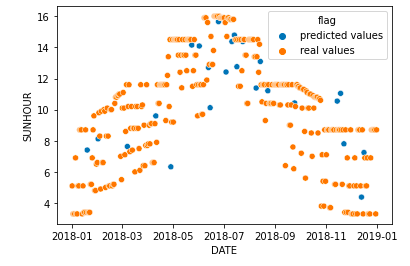

In [122]:
# Setting flag column
df_clean["flag"] = "true values"
df_nan["flag"] = "prediction"

# Concatenate both dataframes (outer)
df2018complete = pd.concat([df_clean, df_nan], axis=0).sort_values(by="DATE")

# Datetime conversion, so the plot will look fine
df2018complete["DATE"] = pd.to_datetime(df2018complete["DATE"])

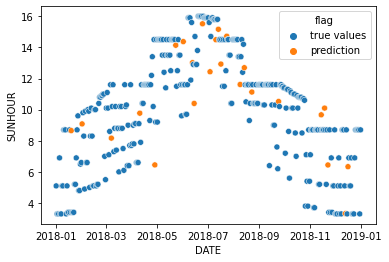

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
sns.scatterplot(data=df2018complete, x="DATE", y="SUNHOUR", hue="flag")